In [9]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import sampler
from torch.utils.data import DataLoader

import torchvision.datasets as dset
import torchvision.transforms as T

import timeit

import models
import solver
import views
import model_net_arch

In [28]:
dtype = torch.FloatTensor
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor

print_every = 100

def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
    
    
def show_solver_training(solver):
    views.show_traning(solver.loss_history, solver.train_acc_history, solver.val_acc_history)

    
def show_mean_and_std_hist(parameters):
    paras = [w.data.cpu().numpy() for w in parameters]
    views.plot_mean_std_hist(paras)

    
def show_conv_layer_weights(conv_weights):
    conv_weights = conv_weights.data.cpu().numpy()
    conv_weights = conv_weights.transpose(0, 2, 3, 1)
    views.show_conv_weights(conv_weights)

    
def compare_solvers_tranings(solvers_with_labels):
    loss_train_val_acc_with_labels = {}
    for label, solver in solvers_with_labels.items():
        loss_train_val_acc_with_labels[label] = (solver.loss_history, solver.train_acc_history, solver.val_acc_history)
    
    views.compare_trainings(loss_train_val_acc_with_labels)

def compare_training_stats(train_stats):
    loss_train_val_acc_with_labels = { }
    
    for (lr, reg) in train_stats:
        train_acc, val_acc, loss_history = train_stats[(lr, reg)]
        loss_train_val_acc_with_labels[str(lr) + ' ' + str(reg)] = (loss_history, train_acc, val_acc)
    
    views.compare_trainings(loss_train_val_acc_with_labels)


In [12]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset.
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from"""
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start
        
    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))
    
    def __len__(self):
        return self.num_samples
    
NUM_TRAIN = 49000
NUM_VAL = 1000

NUM_TRAIN_SMALL = 64

cifar10_train_small = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train_small = DataLoader(cifar10_train_small, batch_size=64, sampler=ChunkSampler(NUM_TRAIN_SMALL, 0))

cifar10_train = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_val = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
# cifar10_val = cifar10_train # can do this?
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('../cs231n/datasets/', train=False, download=True, transform=T.ToTensor())
loader_test = DataLoader(cifar10_test, batch_size=64)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [14]:
torch.cuda.random.manual_seed(12345)

train_stats = { }

model_feature_type = 'A1'
model_classifier_type = 'base'
use_batch_norm = True

sf_model = model_net_arch.DepthNet(model_feature_type, model_classifier_type, use_batch_norm).type(dtype)
sf_loss_fn = nn.CrossEntropyLoss().type(dtype)

max_count = 10

for i in range(max_count):
    lr = 10**np.random.uniform(-5, -1)
    reg = 10**np.random.uniform(-6, -1)

    num_epochs = 5

    step_size = 0
    gamma = 0
    verbose = False
    
    sf_model.apply(reset)

    sf_optimizer = optim.SGD(sf_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
    #sf_lr_scheduler = lr_scheduler.StepLR(sf_optimizer, step_size=step_size, gamma=gamma)
    sf_lr_scheduler = None
    
    sf_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                          model=sf_model,
                                          loss_fn=sf_loss_fn,
                                          optimizer=sf_optimizer,
                                          scheduler=sf_lr_scheduler,
                                          dtype=dtype,
                                          num_epochs=num_epochs,
                                          verbose=verbose
                                         )

    sf_solver.train()
    
    train_stats[(lr, reg)] = (sf_solver.train_acc_history, sf_solver.val_acc_history, sf_solver.loss_history)
    print('val accuracy: %f, train accuracy: %f, final loss: %f, lr: %e, reg: %e' % (
        sf_solver.val_acc_history[-1], sf_solver.train_acc_history[-1], sf_solver.loss_history[-1], lr, reg))

KeyboardInterrupt: 

   lr = 10**np.random.uniform(-5, -1)
    reg = 10**np.random.uniform(-6, -1)

    num_epochs = 5

    step_size = 0

val accuracy: 0.669000, train accuracy: 0.704102, final loss: 0.886562, lr: 5.097211e-04, reg: 1.476795e-02
val accuracy: 0.650000, train accuracy: 0.700195, final loss: 0.728802, lr: 1.115235e-03, reg: 1.426073e-05
val accuracy: 0.601000, train accuracy: 0.617188, final loss: 1.221667, lr: 1.057765e-04, reg: 5.746870e-04
val accuracy: 0.476000, train accuracy: 0.489258, final loss: 1.634470, lr: 1.611056e-05, reg: 1.016738e-03
val accuracy: 0.604000, train accuracy: 0.612305, final loss: 1.184278, lr: 9.471513e-05, reg: 2.418831e-02
val accuracy: 0.453000, train accuracy: 0.457031, final loss: 1.687830, lr: 1.263513e-05, reg: 2.139785e-04
val accuracy: 0.522000, train accuracy: 0.534180, final loss: 0.999135, lr: 1.009833e-03, reg: 5.066756e-02
val accuracy: 0.498000, train accuracy: 0.480469, final loss: 1.618997, lr: 1.816042e-05, reg: 3.532276e-04
val accuracy: 0.434000, train accuracy: 0.454102, final loss: 0.693470, lr: 1.100232e-02, reg: 3.050811e-03
val accuracy: 0.514000, train accuracy: 0.548828, final loss: 1.128294, lr: 6.751685e-02, reg: 3.279891e-03
    
    ---

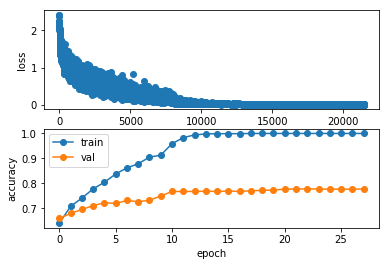

In [19]:
show_solver_training(sf_solver)

In [15]:
import torchsummary.torchsummary

In [16]:
torchsummary.summary(sf_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
           Flatten-9                 [-1, 4096]               0
           Linear-10                 [-1, 1024]       4,195,328
             ReLU-11                 [-1, 1024]               0
           Linear-12                   [-1, 10]          10,250
BaseClassiferHead-13                   [-1, 10]               0
Total params: 4,225,162
Trainable param

In [36]:
model_feature_type = 'A1'
model_classifier_type = 'squeeze'
use_batch_norm = True

model = model_net_arch.DepthNet(model_feature_type, model_classifier_type, use_batch_norm).type(dtype)
torchsummary.summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
           Dropout-9             [-1, 64, 8, 8]               0
           Conv2d-10             [-1, 10, 8, 8]             650
             ReLU-11             [-1, 10, 8, 8]               0
        AvgPool2d-12             [-1, 10, 1, 1]               0
GlobalAveragePool2d-13             [-1, 10, 1, 1]               0
          Flatten-14                 